In [7]:
import numpy as np
np.random.seed(1337)
import tensorflow as tf
import keras

import matplotlib.pyplot as plt

from keras import backend as K

from keras.models import Model

from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from keras.utils import to_categorical
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import larq as lq
from quantized.layers import QuantConv2D,QuantDense
from quantized.models import summary
from quantized.math import binary_tanh as binary_ops
from quantized.quantizers import DoReFaQuantizer,ste_sign

In [8]:
#customized activation function
def binary_tanh(x):
    return binary_ops(x)

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

In [9]:
#inception net basic module function to be used while creating network
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1=QuantConv2D(filters_1x1, (1, 1),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(x)
    
    conv_3x3=QuantConv2D(filters_3x3_reduce, (1, 1),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(x)
    conv_3x3=QuantConv2D(filters_3x3, (3, 3),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(conv_3x3)

    conv_5x5=QuantConv2D(filters_5x5_reduce, (1, 1),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(x)

    conv_5x5=QuantConv2D(filters_5x5, (5, 5),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj=QuantConv2D(filters_pool_proj, (1, 1),**kwargs,use_bias=bias_init, padding="same",activation=binary_tanh)(pool_proj)

    output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [11]:
#creating layers of GoogleNet
from tensorflow.keras.layers import Dense, Dropout, Flatten,MaxPooling2D
input_layer = tf.keras.Input(shape=(227, 227, 3))
np.random.seed(0)
x=(QuantConv2D(64, (7, 7),strides=(2,2),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=bias_init,padding='same',activation='relu')(input_layer))

#x = QuantConv2D(64, (7, 7),strides=(2, 2),kernel_quantizer="ste_sign",kernel_constraint="weight_clip",use_bias=bias_init, padding="same",activation='relu',name='conv_1_7x7/2')(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
#x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = QuantConv2D(64, (1, 1),strides=(1, 1), padding="same",activation=binary_tanh,name='conv_2a_3x3/1')(x)

#x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = QuantConv2D(192, (3, 3),strides=(1, 1), padding="same",activation=binary_tanh,name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = tf.keras.layers.AvgPool2D((5, 5), strides=3)(x)
#x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = QuantConv2D(128, (1, 1), padding="same",activation=binary_tanh)(x1)
x1 = tf.keras.layers.Flatten()(x1)
x1 = Dense(1024, activation=binary_tanh)(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(2, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = tf.keras.layers.AvgPool2D((5, 5), strides=3)(x)
#x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = QuantConv2D(128, (1, 1), padding="same",activation=binary_tanh)(x2)
x2 = tf.keras.layers.Flatten()(x2)
x2 = Dense(1024, activation=binary_tanh)(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(2, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(2, activation='softmax', name='output')(x)

In [12]:
model = tf.keras.Model(input_layer, x, name='inception_v1')
#if you want to use full feature of googlenet use below command but this inflate number of parameters by twice and vey slow
#model = Model(input_layer, [x,x1,x2], name='inception_v1') 
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
quant_conv2d_58 (QuantConv2D)   (None, 114, 114, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 57, 57, 64)   0           quant_conv2d_58[0][0]            
__________________________________________________________________________________________________
conv_2a_3x3/1 (QuantConv2D)     (None, 57, 57, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [13]:
#loading and preprocessing data from dataset
#please change path as per dataset in your system
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/training_set/training_set",target_size=(227,227))
trdata = ImageDataGenerator()
testdata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/test_set/test_set",target_size=(227,227))


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [14]:
from keras.optimizers import Adam
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt = Adam(lr=0.001)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#defining Earlystopping callback and saving the best model for future use
checkpoint = ModelCheckpoint("googlenet_fp.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
from keras.preprocessing.image import ImageDataGenerator
#training and validating train and validation data respectively
hist = model.fit_generator(steps_per_epoch=2,generator=traindata, validation_data= testdata, 
                           validation_steps=10,epochs=150,callbacks=[checkpoint,early],shuffle=False,use_multiprocessing=False)


Epoch 1/150
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1/2 [==============>...............] - ETA: 51s - loss: 0.7116 - acc: 0.5312
Epoch 00001: val_acc improved from -inf to 0.51562, saving model to googlenet_fp.h5
2/2 [==============================] - 145s 72s/step - loss: 2.5228 - acc: 0.4844 - val_loss: 2.3314 - val_acc: 0.5156
Epoch 2/150
1/2 [==============>...............] - ETA: 11s - loss: 2.3299 - acc: 0.5312
Epoch 00002: val_acc did not improve from 0.51562
2/2 [==============================] - 76s 38s/step - loss: 1.6570 - acc: 0.4688 - val_loss: 1.8808 - val_acc: 0.4844
Epoch 3/150
1/2 [==============>...............] - ETA: 14s - loss: 2.0637 - acc: 0.4062
Epoch 00003: val_acc did not improve from 0.51562
2/2 [==============================] - 75s 38s/step - loss: 1.5452 - acc: 0.4531 - val_loss: 0.8110 - val_acc: 0.5156
Epoch 4/150
1/2 [==============>...............] - ETA: 15s - loss: 1.0525 - acc: 0.4375
Epoch 00004

'def generate_data_generator(generator, input_layer, x, x1, x2):\n    genX1 = generator.flow(input_layer, x, seed=7)\n    genX2 = generator.flow(input_layer, x1, seed=7)\n    genX3 = generator.flow(input_layer, x2, seed=7)\n    while True:\n        X1i = genX1.next()\n        X2i = genX2.next()\n        X3i = genX3.next()\n        yield X1i[0], [X1i[1], X2i[1],X3i[1]]\n\nhist = model.fit_generator(generate_data_generator(generator, input_layer, x, x1, x2),steps_per_epoch=10,generator=traindata, validation_data= testdata, validation_steps=10,epochs=10,callbacks=[checkpoint,early])'

In [16]:
#saving model for future use
model.save("model_googlenet_Bnn.h5")
print("Saved model to disk")


Saved model to disk


Training maximum accuracy: 67.19 %
Validation maximum accuracy: 55.62 %
Training model minimum loss: 0.6459066867828369
Validation model minimum loss : 0.6903677880764008


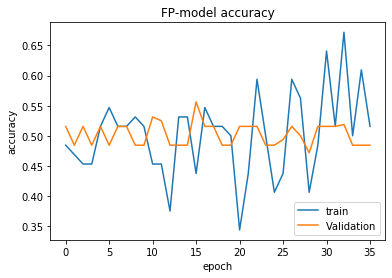

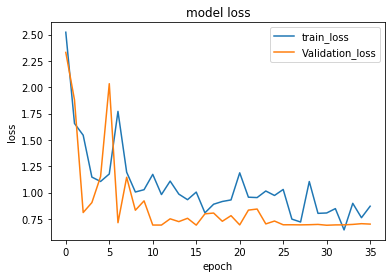

In [17]:
#Graph represenattaion of loss and accuracy
plt.figure()
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title('BNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.figure()
print(f"Training maximum accuracy: {np.max(hist.history['acc']) * 100:.2f} %")
print(f"Validation maximum accuracy: {np.max(hist.history['val_acc']) * 100:.2f} %")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('BNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'Validation_loss'], loc='upper right')

print(f"Training model minimum loss: {np.min(hist.history['loss'])}")
print(f"Validation model minimum loss : {np.min(hist.history['val_loss']) }")
